# Ideal Gas simulation in Python

We simulate the behaviour of an ideal gas as it approaches equilibrium. 
The assumptions we are making are the following: 

* The particles start at random positions and with random velocities.
* The number of particles in the container remains fixed throughout the simulation. 
* The particles do not interact with one another. 
* The particles can collide *elastically* with each other and the boundaries of the container
* In between collisions, the particles move in straight lines. 


## Algorithm 
The idea behind the algorithm to run the simulation is simple: 

* Fix the number of particles, the size of the container and length of simulation.
* Initialize their positions and velocities at time $t=0$. 
* At each time step: check if some of the particles are colliding with one another/the wall. If so, update their velocities accordingly to account for conservation of energy + momentum.
* Once the velocities have been updated, we step the positions of the particles: $\bold r(t+\Delta t) = \bold r(t) + \bold v(t+ \Delta t) \Delta t$.

## Collisions 
### Particle-particle collisions
We use the following formula for updating the velocities of the particles that are colliding:

$$ \bold v_i' = \bold v_i - \frac{(\bold v_i - \bold v_j) \cdot (\bold r_i - \bold r_j)}{(\bold r_i - \bold r_j) \cdot (\bold r_i - \bold r_j)} (\bold r_i - \bold r_j) $$
$$ \bold v_j' = \bold v_j - \frac{(\bold v_j - \bold v_i) \cdot (\bold r_j - \bold r_i)}{(\bold r_j - \bold r_i) \cdot (\bold r_i - \bold r_j)} (\bold r_j - \bold r_i) $$ 

### Particle-wall collisions
When a particle collides with one of the walls, we invert the component of its velocity that is orthogonal to the wall. 

## Maxwell-Boltzmann distribution
As the simulation goes on, the gas should approach equilibrium and the distribution of the particles' velocities should approach the Maxwell-Boltzmann distribution in 2D: 

$$f(v) = \frac{m v}{k_B T} e^{-\frac{mv^2}{2k_BT}}$$

We also have that $k_B T = \langle E \rangle$ the average energy per particle.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
from matplotlib.animation import FuncAnimation 
from IPython.display import HTML

In [2]:
class IdealGas:

    def __init__(self, nparticles, mass, radius,L, duration, nsteps):
        self.nparticles = nparticles #number of particles 
        self.mass = mass #mass of particles (kg)
        self.radius = radius #radius of particles (m)
        self.L = L #length of the box (m)
        self.duration = duration #duration (s)
        self.nsteps = nsteps #number of steps
        self.t = np.linspace(0,duration,nsteps) #time array 
        self.dt = duration/nsteps #timestep
        #initialize positions and velocities
        self.r = np.stack((np.random.uniform(2*radius,L-2*radius, nparticles), 
                           np.random.uniform(2*radius,L-2*radius, nparticles))).T
        
        v0 = 3 #m/s
        theta = np.random.uniform(0,1,nparticles)*2*np.pi #random angles (uniformly distributed)
        self.v = v0*np.stack((np.cos(theta),np.sin(theta))).T #initial velocities

        
        
    def dij(self,r):

        dist_matrix = np.zeros((self.nparticles, self.nparticles))
        for i in range(self.nparticles):
            for j in range(i, self.nparticles):
                dist_matrix[i,j] = np.linalg.norm(r[i]-r[j])

        return dist_matrix

    

    def check_collisions(self):

        """Checks if there has been a collision between 2 particles. If so, 
        updates the velocities taking into account conservation of energy
        and momentum."""
        
        r_next = self.r + self.v*self.dt #next theoretical position of the particles

        #particle collisions
        dist_pairs = self.dij(r_next)
        rows,cols = np.triu_indices(self.nparticles, k=1)
        collisions = np.where(dist_pairs[rows,cols]<=2*self.radius)[0]
        i,j = rows[collisions], cols[collisions]
        vdiff = self.v[i] - self.v[j]
        rdiff = self.r[i] - self.r[j]
        self.v[i] = self.v[i] -rdiff*(np.sum(rdiff*vdiff,axis=1)/(np.sum(rdiff**2,axis=1)))[:,np.newaxis]
        self.v[j] = self.v[j] +rdiff*(np.sum(rdiff*vdiff,axis=1)/(np.sum(rdiff**2,axis=1)))[:,np.newaxis]


        #wall collisions, invert orthogonal velocity component
        self.v[r_next[:,0]<self.radius, 0] *=-1
        self.v[r_next[:,0]>self.L-self.radius,0] *=-1
        self.v[r_next[:,1]<self.radius,1] *=-1
        self.v[r_next[:,1]>self.L-self.radius,1] *=-1


    def step(self): 
        self.check_collisions() #check for collisions
        self.r += self.v*self.dt #step the positions


    def MaxwellBoltzmann(self, v0, v):

        KE_avg = 1/2*self.mass*np.sum(v0**2) * 1/self.nparticles #average kinetic energy
        kT =KE_avg #temperature
        sigma_sq = kT/self.mass #variance of the distribution
        f = np.exp(-v**2/(2*sigma_sq)) * v/sigma_sq #Maxwell-Boltzmann distribution
        return f

    


    def energy(self, velocities):
        #takes as input the velocity of the particles at a certain time. 
        average_energies = [1/2*self.mass*np.sum(v**2) for v in velocities] #average kinetic energy (=total E/N)
        return average_energies


    def animate(self):

        positions = np.zeros((self.nparticles,2,len(self.t))) #empty array to store positions
        velocities = np.zeros((self.nparticles, len(self.t))) #empty array to store velocity norm

        for n,t in enumerate(self.t): #iterate through all timesteps

            self.step() #step 
            positions[:,:,n] = self.r #append to positions
            velocities[:,n] = np.linalg.norm(self.v, axis=1) #append to velocities

        return positions,velocities




    




In [3]:
nparticles = 300
mass, radius = 1,0.25
L = 40
duration, nsteps = 10, 250
gas = IdealGas( nparticles, mass, radius,L, duration, nsteps)
pos, vel = gas.animate()

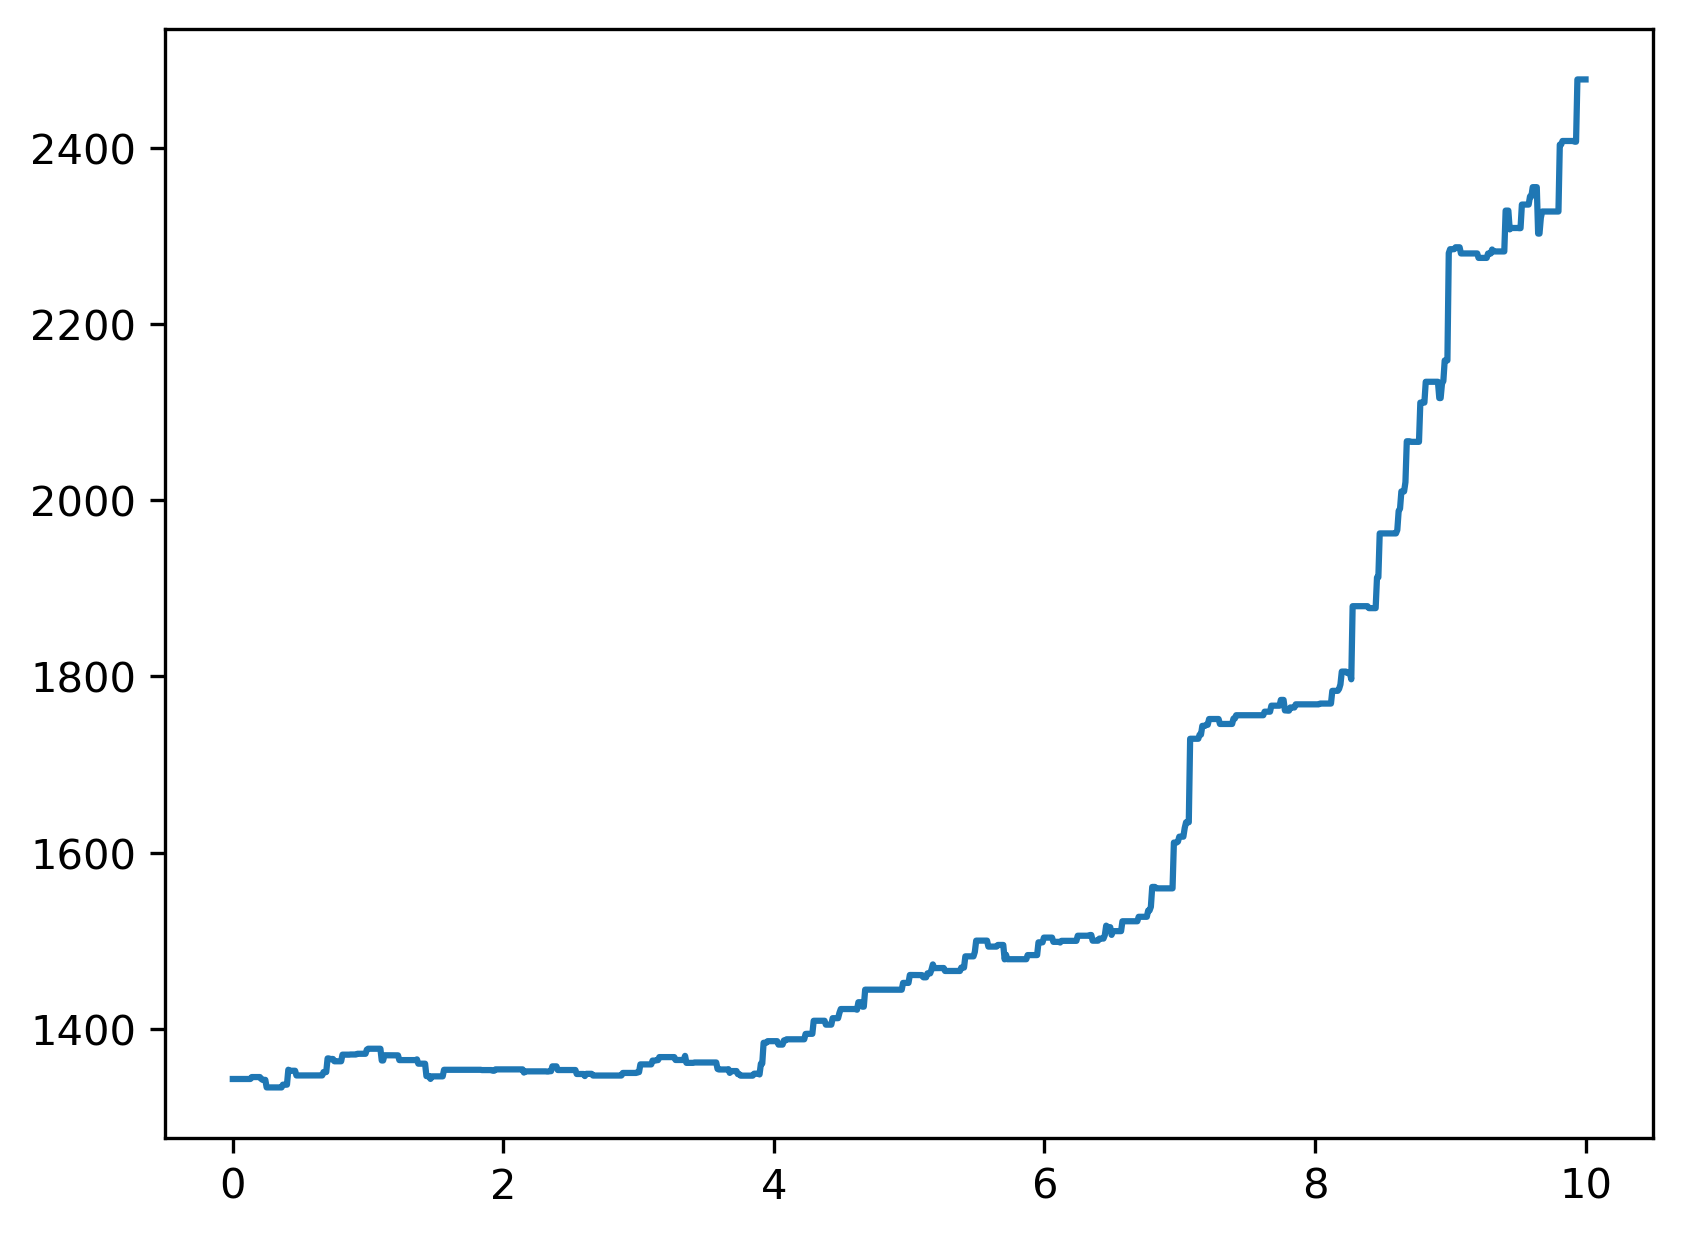

In [4]:
Et = gas.energy(vel.T)
plt.plot(gas.t, Et)
    

In [5]:
v0 = vel.T[0]
v  = np.linspace(0,35, 100)
f = gas.MaxwellBoltzmann(v0, v)

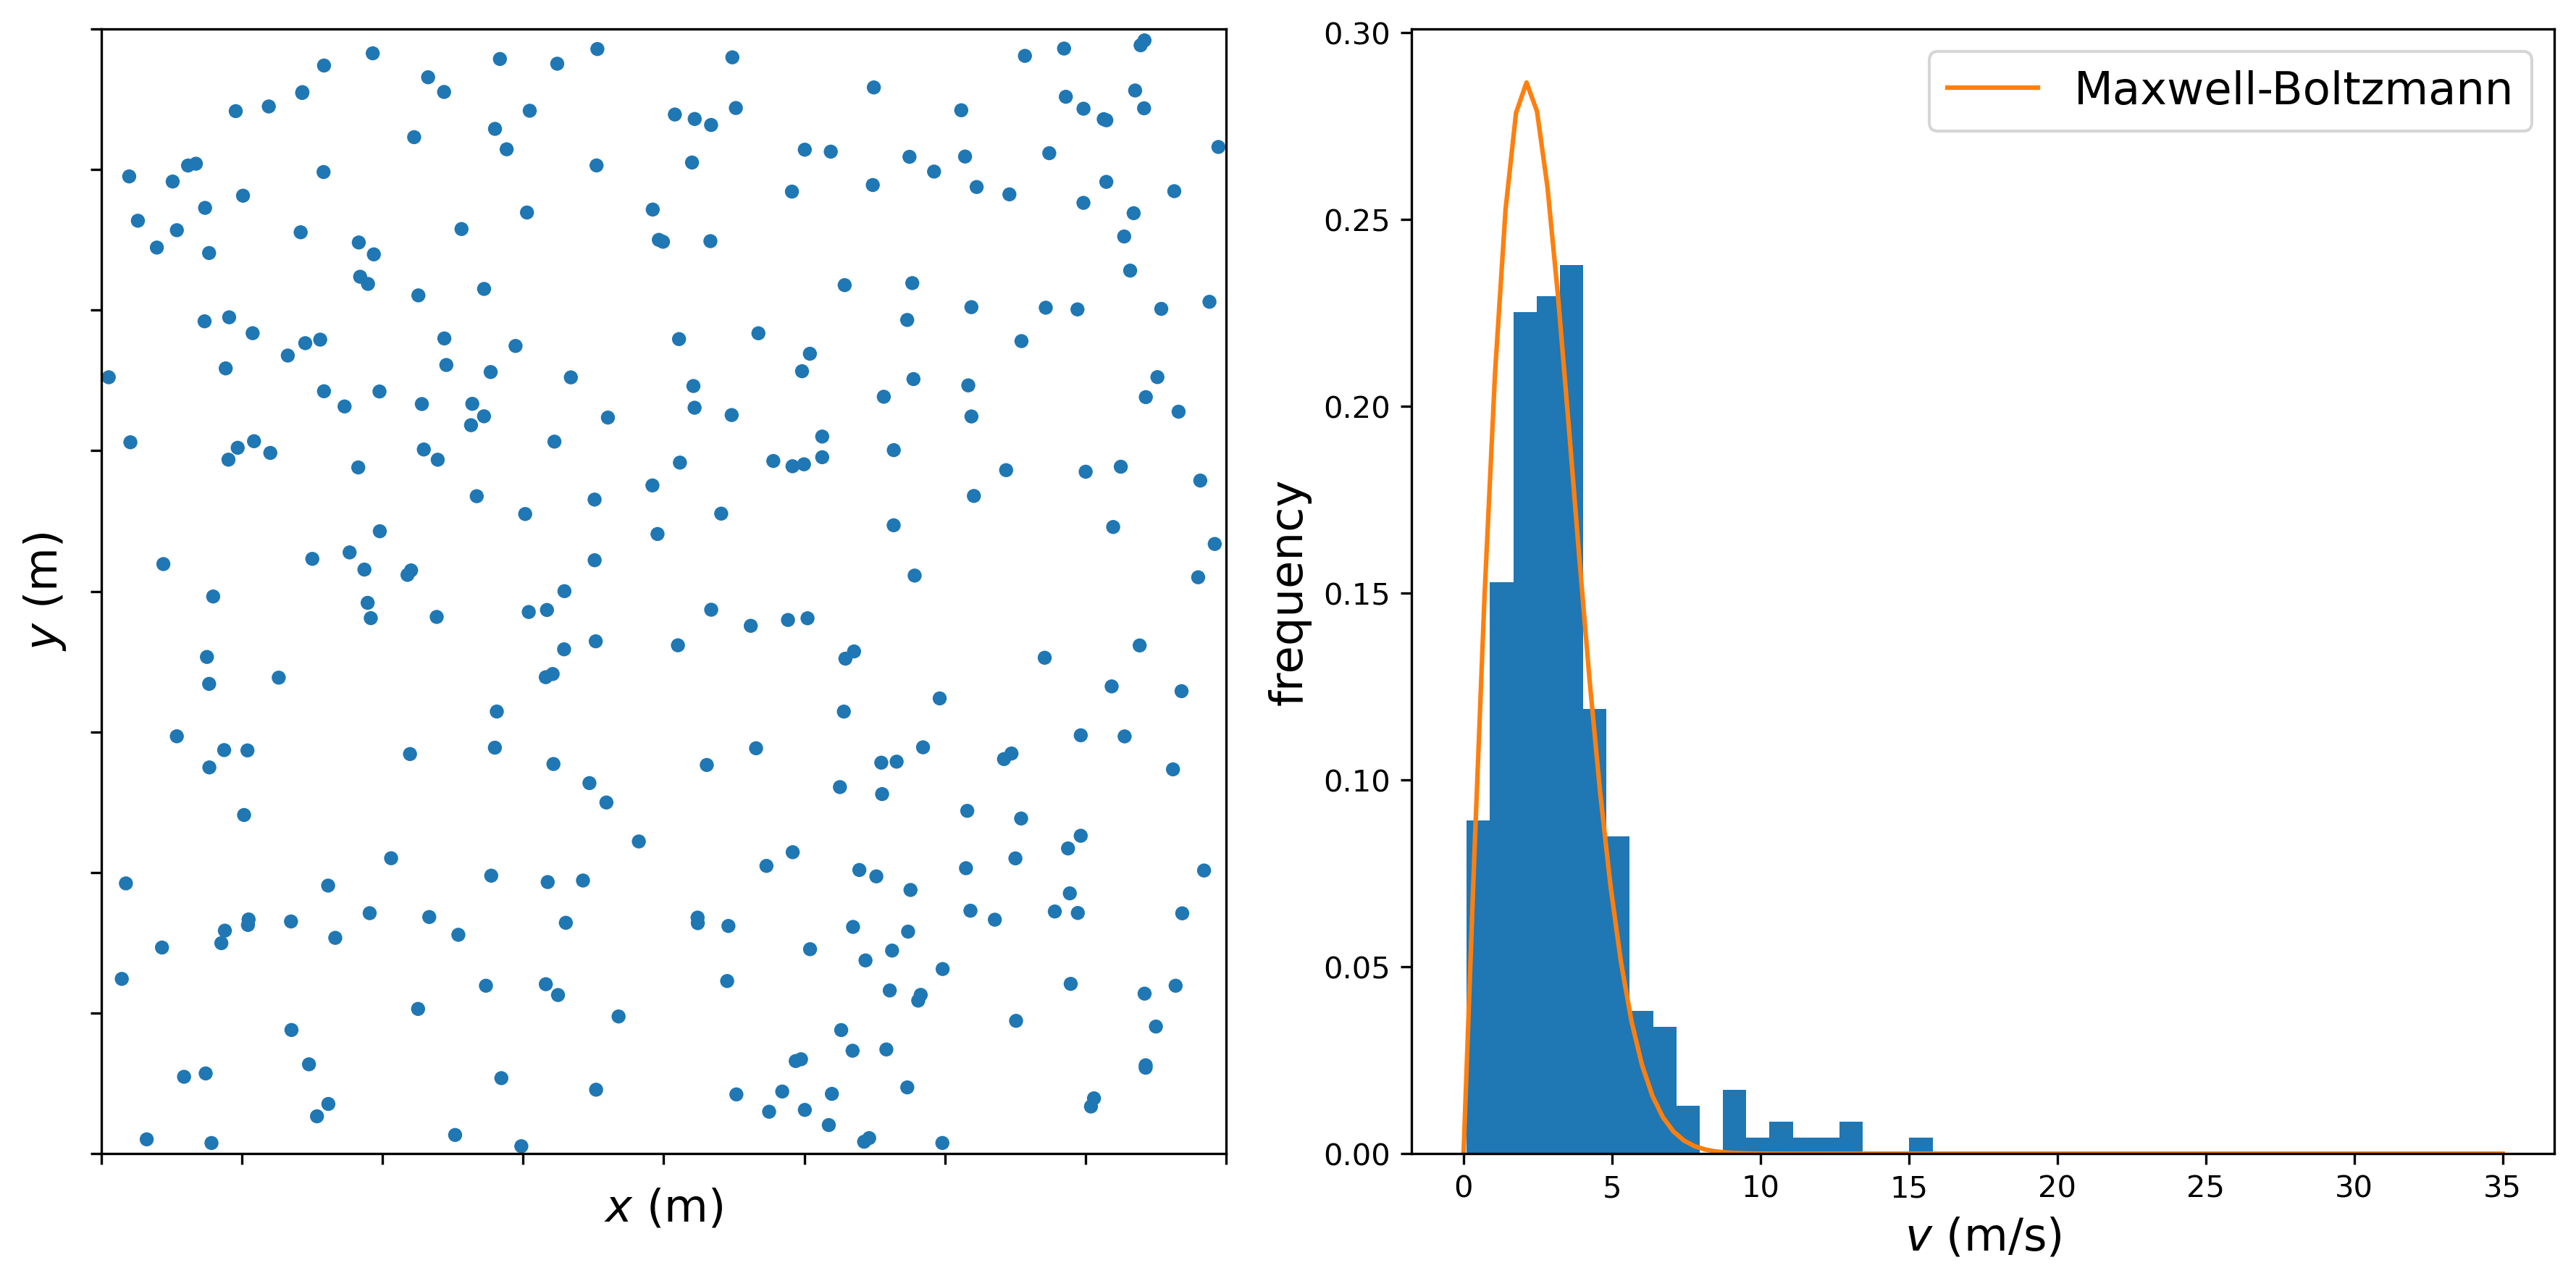

In [6]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,6))

ax1.set_xticklabels([])
ax1.set_yticklabels([])





for i in range(gas.nparticles):
    x,y = pos[i,0,-1], pos[i,1,-1]
    circle = plt.Circle((x, y), gas.radius, fill=True)
    ax1.add_artist(circle)

ax1.set_xlim(0,L)
ax1.set_ylim(0,L)
ax1.set_aspect('equal')
ax1.set_xlabel('$x$ (m)', fontsize=15)
ax1.set_ylabel('$y$ (m)', fontsize=15)


ax2.hist(vel.T[-1], density=True, bins = 20)
ax2.set_xlabel('$v$ (m/s)', fontsize=15)
ax2.set_ylabel('frequency', fontsize=15)
ax2.plot(v,f, label = 'Maxwell-Boltzmann')
ax2.legend(fontsize=15)

plt.tight_layout()


In [7]:
vmin, vmax = vel.T[-1].min(), vel.T[-1].max()
v0 = vel.T[0]
v  = np.linspace(0,50, 500)
f = gas.MaxwellBoltzmann(v0, v)

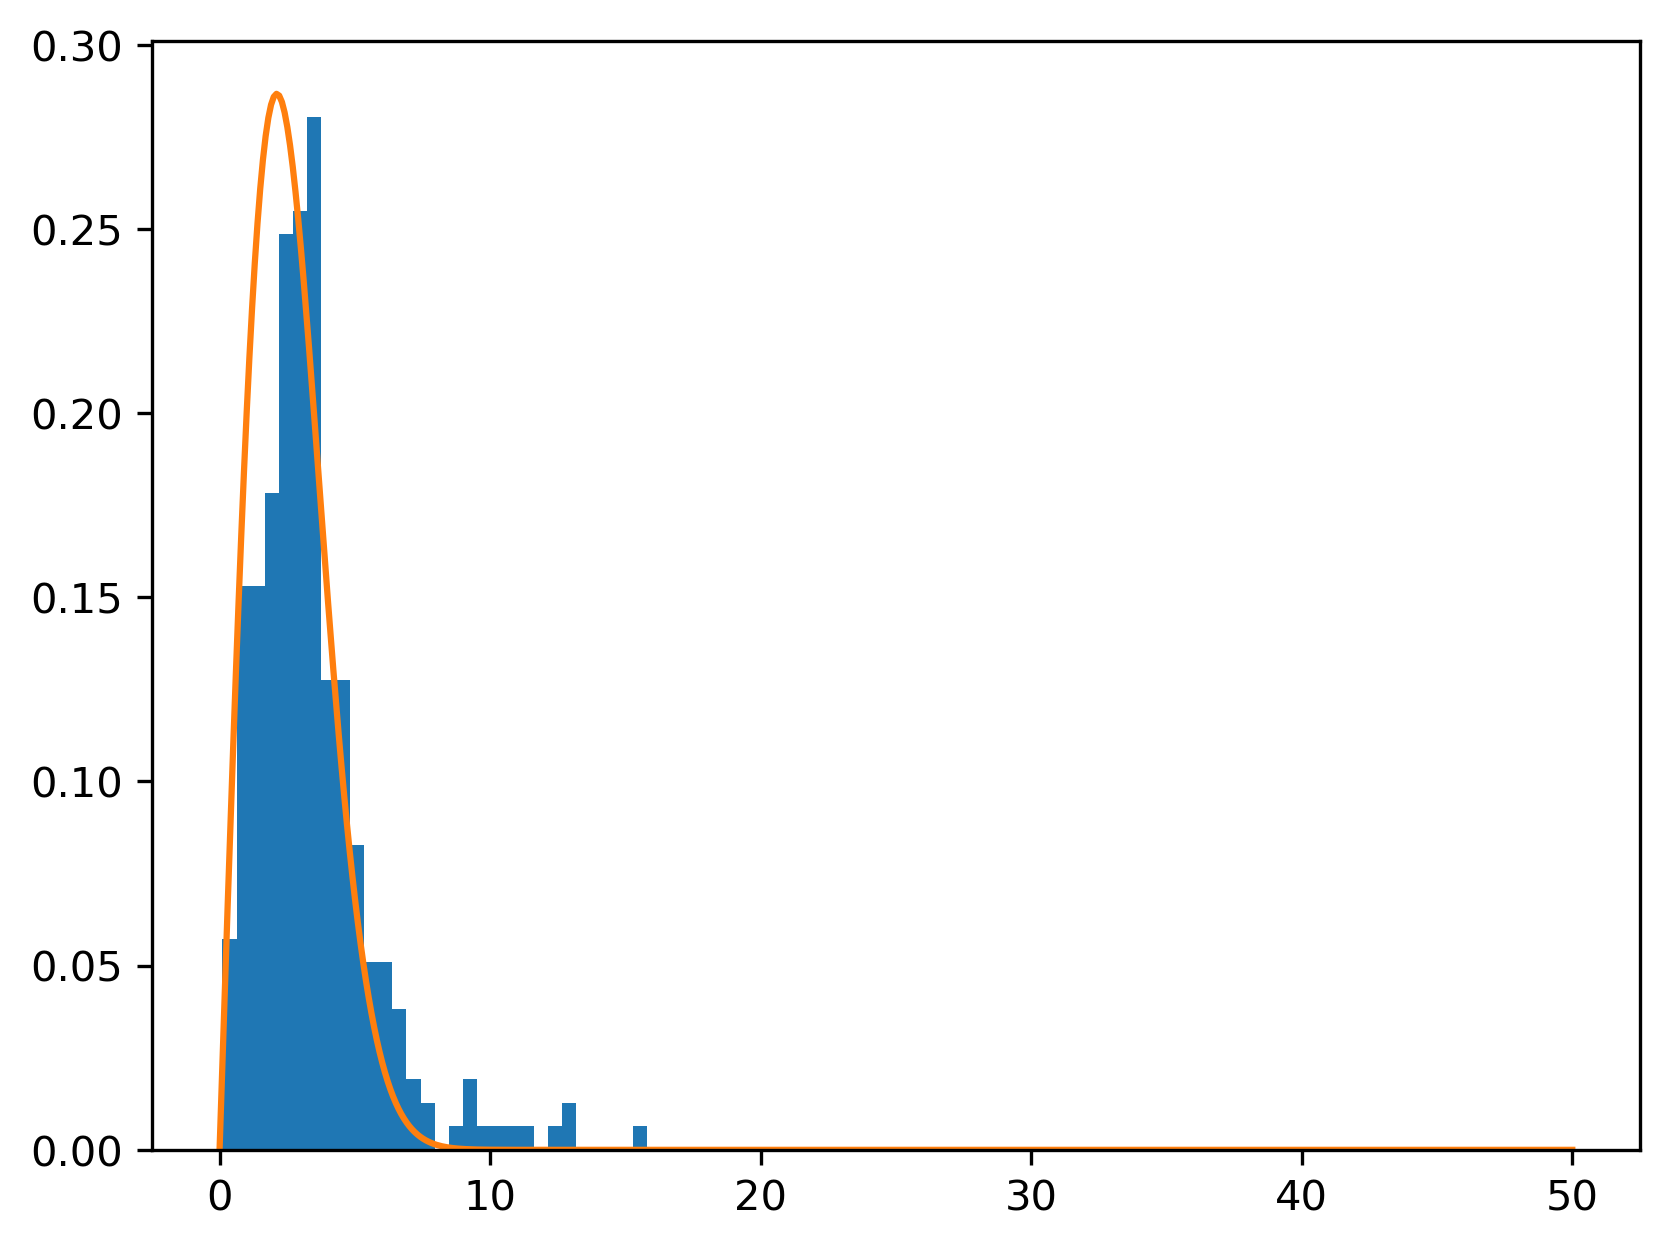

In [8]:
plt.hist(vel.T[-1], density=True, bins = 30)
plt.plot(v,f)

In [9]:
vel.T[0]

array([3.        , 4.18842922, 3.        , 3.        , 3.        ,
       3.        , 3.        , 3.56013881, 3.        , 3.        ,
       3.        , 3.        , 3.        , 3.        , 3.        ,
       3.        , 3.        , 3.        , 3.        , 3.        ,
       0.75240972, 3.        , 0.3555652 , 3.        , 3.        ,
       3.        , 3.        , 3.        , 3.        , 3.        ,
       3.        , 3.        , 3.        , 3.        , 2.32329828,
       3.        , 3.        , 3.        , 3.        , 3.        ,
       3.        , 3.        , 3.        , 3.        , 0.67606261,
       3.        , 3.        , 3.        , 3.        , 0.72831219,
       3.        , 0.89494576, 3.        , 3.        , 3.        ,
       3.        , 3.        , 3.        , 3.        , 3.        ,
       3.        , 3.        , 3.        , 3.        , 3.        ,
       4.17966043, 3.        , 2.92337969, 3.        , 3.        ,
       3.        , 3.        , 3.        , 3.        , 3.     

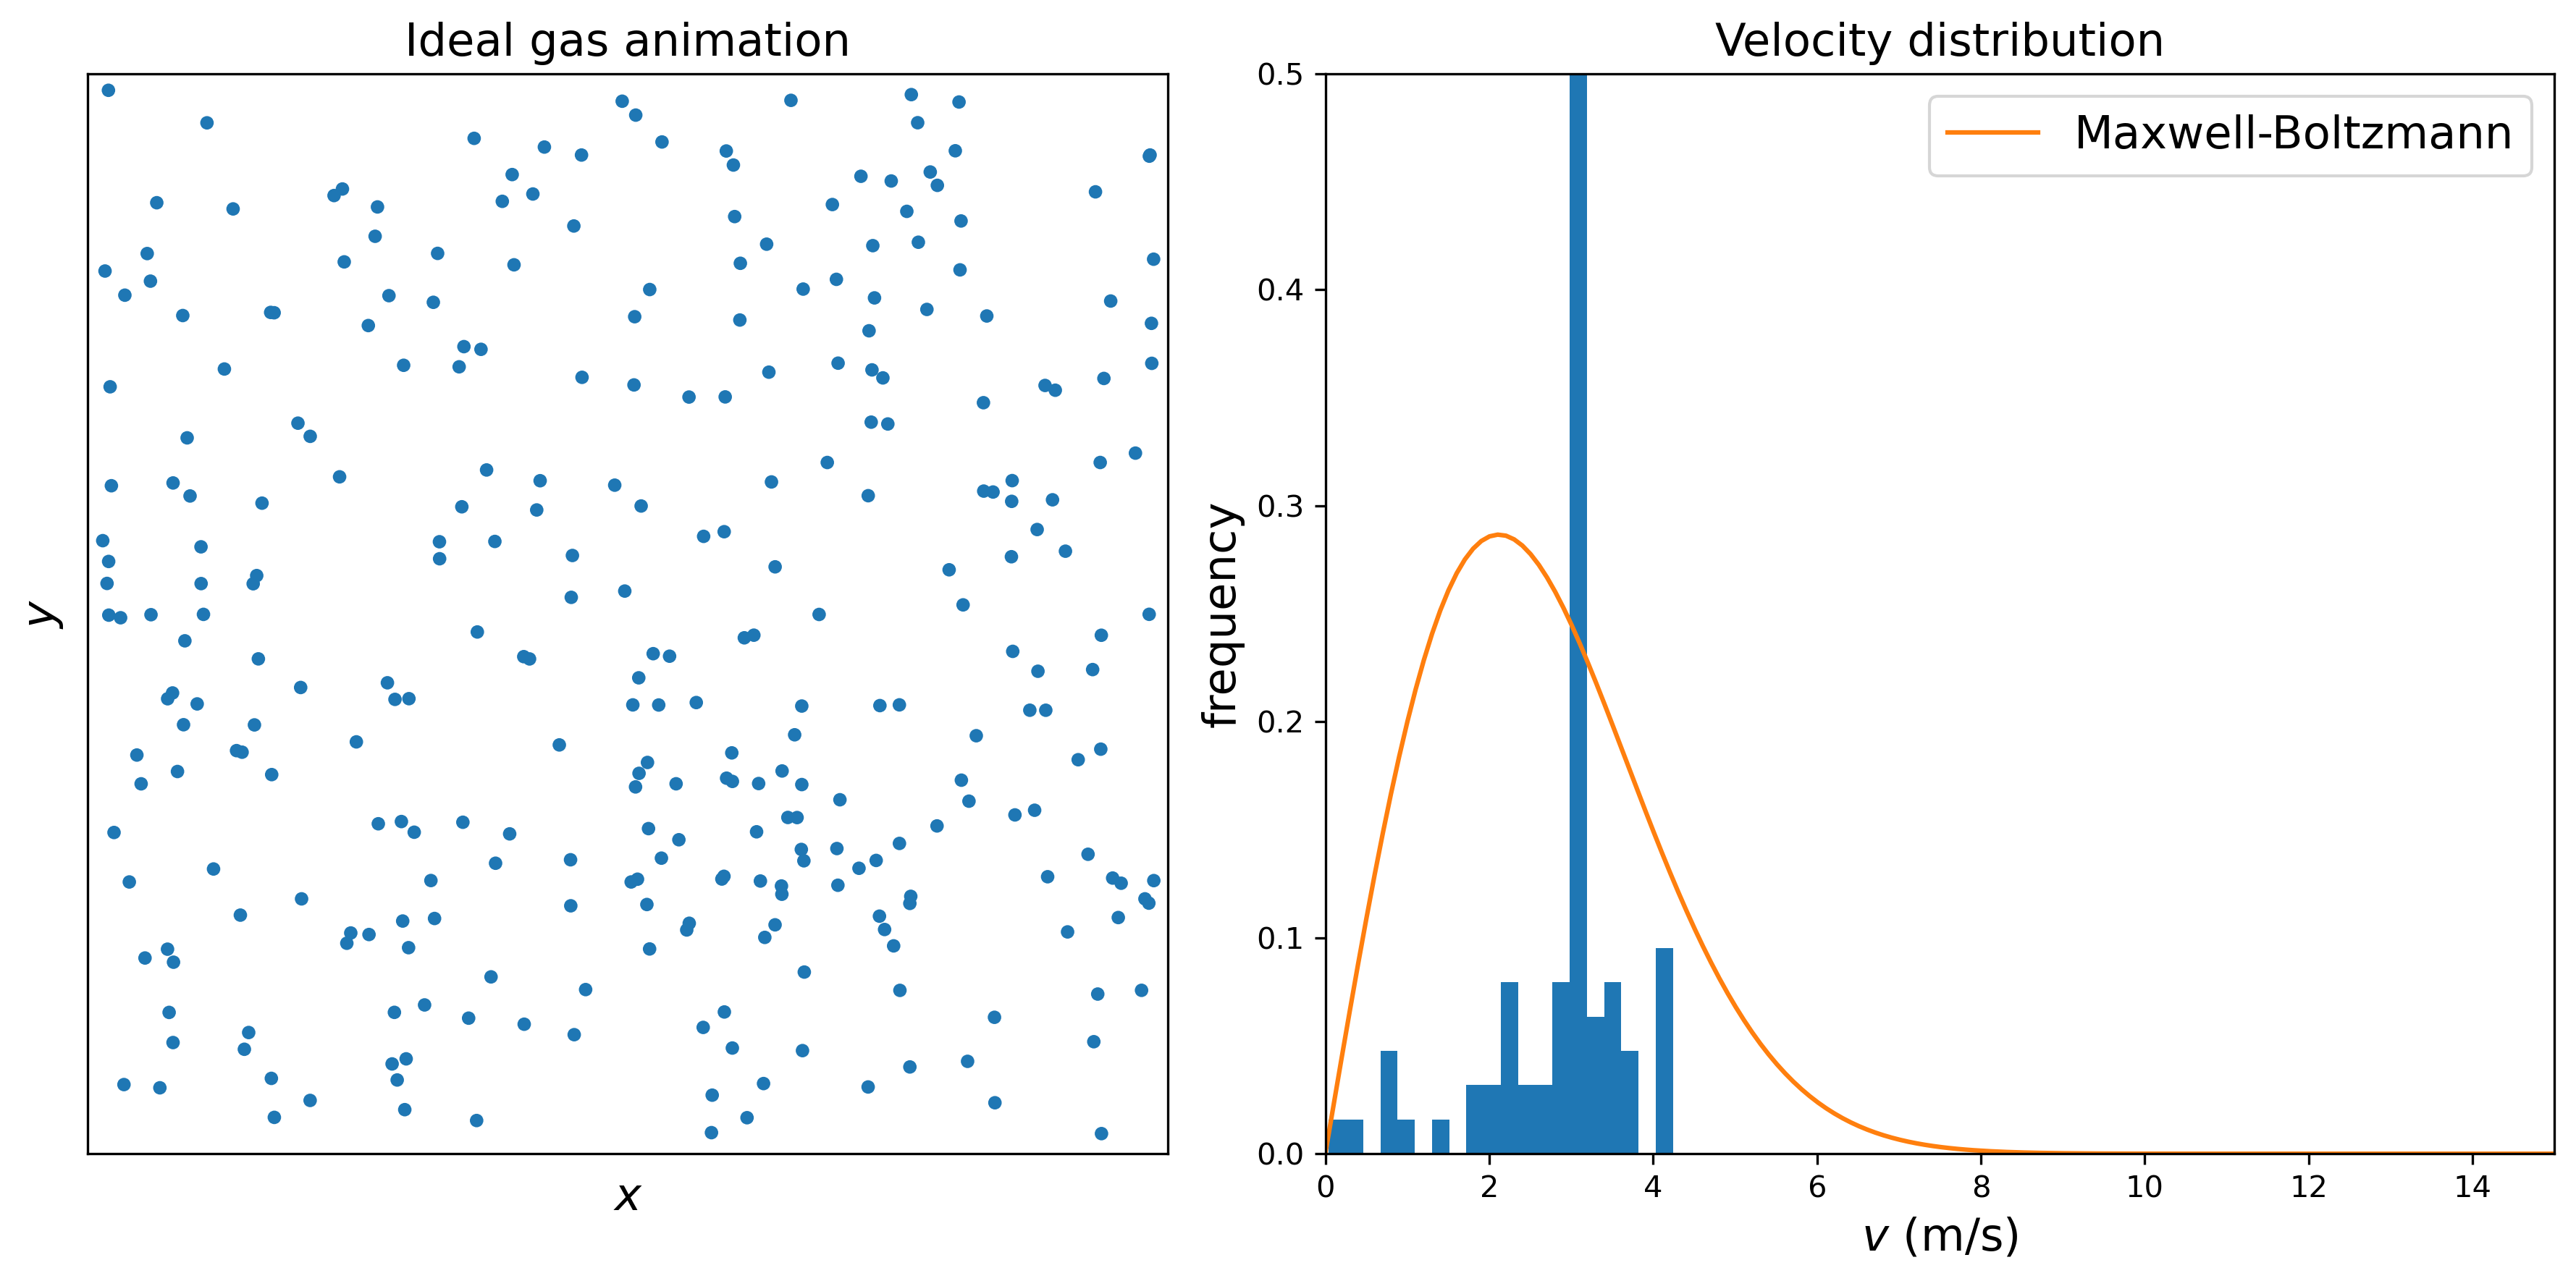

In [10]:


fig,(ax1,ax2) = plt.subplots(1,2, figsize = (12,6))

def animate_positions(frame):
    ax1.clear()
    ax2.clear()
    for i in range(gas.nparticles):
        x, y = pos[i, 0, frame], pos[i, 1, frame]
        circle = plt.Circle((x, y), gas.radius, fill=True)
        ax1.add_artist(circle)


    ax2.hist(vel.T[frame], density=True, bins=20)

    ax1.set_xlabel('$x$', fontsize=15)
    ax1.set_ylabel('$y$', fontsize=15)
    ax1.set_title('Ideal gas animation', fontsize=15)
    ax1.set_xlim(0, gas.L)
    ax1.set_ylim(0, gas.L)
    ax1.set_aspect('equal')
    ax1.set_xticks([]) #remove ticks
    ax1.set_yticks([])

    ax2.set_xlim(0, 15)
    ax2.set_ylim(0, 0.5)
    ax2.set_xlabel('$v$ (m/s)', fontsize=15)
    ax2.set_ylabel('frequency', fontsize=15)
    ax2.set_title('Velocity distribution', fontsize=15)
    ax2.plot(v,f, label = 'Maxwell-Boltzmann')
    ax2.legend(fontsize=15)

    plt.tight_layout()



interval = duration*1e3/nsteps
animation = FuncAnimation(fig, animate_positions, frames=nsteps, interval=interval)

HTML(animation.to_html5_video())